In [701]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import recall_score


### Splitting Train/Test and OHE categorical columns

In [702]:
df = pd.read_parquet("../../01_data/processed/dataset_clean.parquet")

X = df.drop(columns=["y"])
y = df["y"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape

((24382, 19), (6096, 19))

In [703]:
cat_cols = X_train.select_dtypes(include="object").columns
num_cols = X_train.select_dtypes(exclude="object").columns

cat_cols, num_cols

(Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
        'month', 'day_of_week', 'poutcome'],
       dtype='object'),
 Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
        'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
       dtype='object'))

In [704]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

### Logistic regression (baseline)

In [705]:
lr = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",  #class imbalance
    random_state=42
)

In [706]:
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", lr),
    ]
)

model.fit(X_train, y_train)

c:\Users\joeps\anaconda3\envs\py311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [707]:
lr_pred = model.predict(X_test)
lr_proba = model.predict_proba(X_test)[:, 1]

confusion_matrix(y_test, lr_pred)

array([[4373,  951],
       [ 274,  498]])

In [708]:
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.94      0.82      0.88      5324
           1       0.34      0.65      0.45       772

    accuracy                           0.80      6096
   macro avg       0.64      0.73      0.66      6096
weighted avg       0.87      0.80      0.82      6096



In [709]:
lr_AUC = roc_auc_score(y_test, lr_proba) #Logistic regression AUC as baseline
lr_AUC

0.7882944278134404

In [710]:
precision, recall, thresholds = precision_recall_curve(y_test, lr_proba)

avg_precision = average_precision_score(y_test, lr_proba)
avg_precision

0.4303465132104892

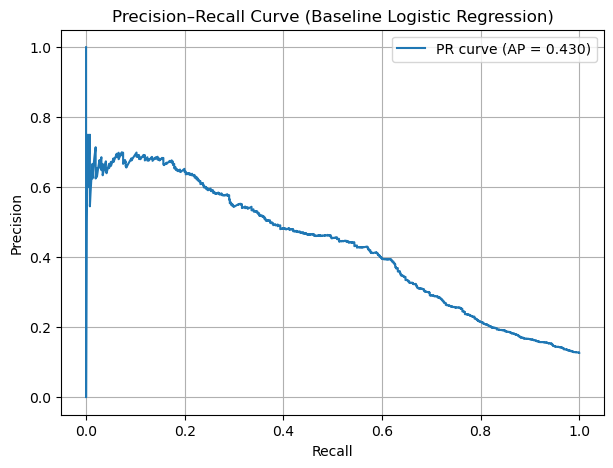

In [711]:
plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f"PR curve (AP = {avg_precision:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Baseline Logistic Regression)")
plt.legend()
plt.grid(True)
plt.show()

In [712]:
# Precision 0.3, 0.35, 0.4, 0.45, 0.50 with max recall (chosen to make recall heavy artifact metric due to cost of missed opportunity being higher than cost of non-prospect being mislabeled as opportunity)
# Precision of calling everyone = TP/total test set = 0.13

constraints = [0.30, 0.35, 0.40, 0.45, 0.50]

for p in constraints:
    r = recall[:-1][precision[:-1] >= p].max()
    print(f"precision ≥ {p:.2f} → recall = {r:.3f}")


precision ≥ 0.30 → recall = 0.696
precision ≥ 0.35 → recall = 0.639
precision ≥ 0.40 → recall = 0.598
precision ≥ 0.45 → recall = 0.513
precision ≥ 0.50 → recall = 0.374


In [713]:
pr_df = pd.DataFrame({
    "threshold": thresholds,
    "precision": precision[:-1],
    "recall": recall[:-1],
})


candidate_thresholds = pr_df[pr_df["precision"] >= 0.35]
candidate_thresholds.sort_values("recall", ascending=False).head()

,threshold,precision,recall
4618,0.511770,0.350142,0.638601
4621,0.513750,0.350890,0.638601
4622,0.514225,0.351140,0.638601
4619,0.512191,0.350391,0.638601
4620,0.512979,0.350640,0.638601


In [714]:
# Chosen parameter for artifact = 0.35
# Accompanying threshold = 0.512, meaning a call gets made when model predicts y=1 with 51% certainty. Threshold only helps create confusion matrix and does not explain model performance in itself.

chosen_precision = 0.35

chosen_row = summary_df[summary_df["min_precision"] == chosen_precision].iloc[0]

lr_chosen_threshold = chosen_row["threshold"]
lr_chosen_threshold

np.float64(0.3732765435014003)

In [715]:
# Model performance with chosen parameter

y_pred_final_lr = (lr_proba >= chosen_threshold).astype(int)

confusion_matrix(y_test, y_pred_final_lr)

array([[3737, 1587],
       [ 207,  565]])

In [716]:
print(classification_report(y_test, y_pred_final_lr, digits=3))

              precision    recall  f1-score   support

           0      0.948     0.702     0.806      5324
           1      0.263     0.732     0.386       772

    accuracy                          0.706      6096
   macro avg      0.605     0.717     0.596      6096
weighted avg      0.861     0.706     0.753      6096



### Random forest classifier

In [717]:
rfc = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=50,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

In [718]:
rfc_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", rfc)
])

rfc_pipe.fit(X_train, y_train)
rfc_proba = rfc_pipe.predict_proba(X_test)[:, 1]

rfc_proba

array([0.45360551, 0.20096559, 0.80842838, ..., 0.29485267, 0.23980326,
       0.2301527 ], shape=(6096,))

In [719]:
rfc_AUC = roc_auc_score(y_test, rfc_proba)
rfc_AUC

0.7981773317035381

In [720]:
# calculate rfc average precision and compare with lr precision of 0.430

rfc_precision, rfc_recall, rfc_thresholds = precision_recall_curve(y_test, rfc_proba)
rfc_ap = average_precision_score(y_test, rfc_proba)

rfc_ap

0.4603036580554547

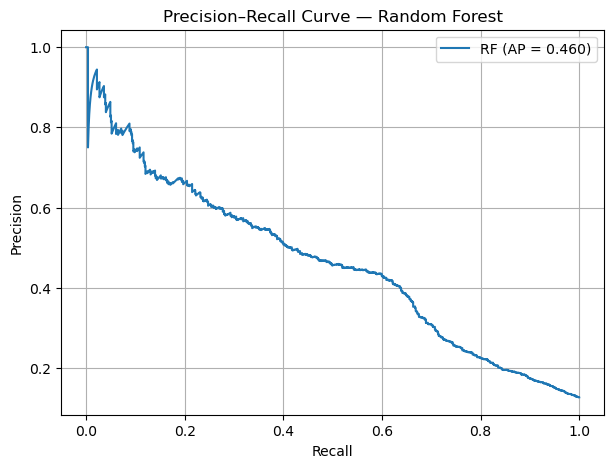

In [721]:
plt.figure(figsize=(7, 5))
plt.plot(rfc_recall, rfc_precision, label=f"RF (AP = {rfc_ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Random Forest")
plt.legend()
plt.grid(True)
plt.show()

In [722]:
# Precision 0.35 with max recall (same as lr)

print(f"Random Forest:       {recall_at_precision(y_test, rfc_proba, 0.35):.3f}")

Random Forest:       0.667


In [723]:
# Chosen parameter for artifact = 0.35
# Accompanying threshold = 0.467, meaning a call gets made when model predicts y=1 with 46.7% certainty

rfc_chosen_row = rfc_summary_df[rfc_summary_df["min_precision"] == chosen_precision].iloc[0]

rfc_chosen_threshold = rfc_chosen_row["threshold"]
rfc_chosen_threshold

np.float64(0.36243142387709076)

In [724]:
# Model performance with chosen parameter

y_pred_final_rfc = (rfc_proba >= rfc_chosen_threshold).astype(int)

confusion_matrix(y_test, y_pred_final_rfc)

array([[3770, 1554],
       [ 205,  567]])

In [725]:
print(classification_report(y_test, y_pred_final_rfc, digits=3))

              precision    recall  f1-score   support

           0      0.948     0.708     0.811      5324
           1      0.267     0.734     0.392       772

    accuracy                          0.711      6096
   macro avg      0.608     0.721     0.601      6096
weighted avg      0.862     0.711     0.758      6096



### XGBoost

In [726]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

xgb_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", xgb)
])

xgb_pipe.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [727]:
xgb_proba = xgb_pipe.predict_proba(X_test)[:, 1]

xgb_precision, xgb_recall, xgb_thresholds = precision_recall_curve(y_test, xgb_proba)
xgb_ap = average_precision_score(y_test, xgb_proba)

In [728]:
xgb_AUC = roc_auc_score(y_test, xgb_proba)
xgb_AUC

0.8009648361316242

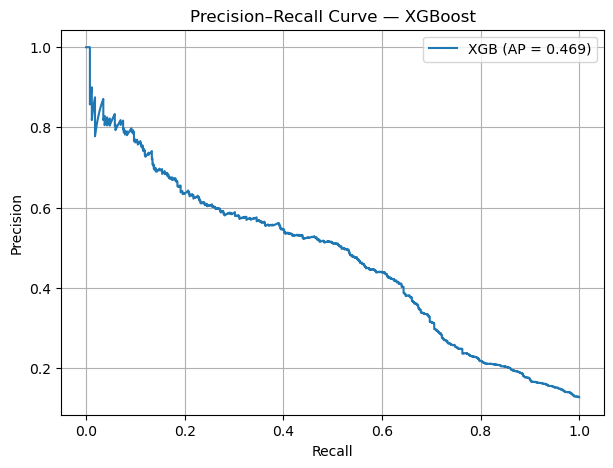

In [729]:
plt.figure(figsize=(7, 5))
plt.plot(xgb_recall, xgb_precision, label=f"XGB (AP = {xgb_ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — XGBoost")
plt.legend()
plt.grid(True)
plt.show()

In [730]:
print(f"XGBoost:        {recall_at_precision(y_test, xgb_proba, 0.35):.3f}")

XGBoost:        0.674


In [731]:
# Find threshold for precision >= 0.35 with max recall
idx = np.argmax(xgb_recall[:-1][xgb_precision[:-1] >= chosen_precision])
xgb_threshold = xgb_thresholds[xgb_precision[:-1] >= chosen_precision][idx]

# Predicitons at chosen threshold
y_pred_xgb = (xgb_proba >= xgb_threshold).astype(int)

# Evaluation
confusion_matrix(y_test, y_pred_xgb)

array([[4359,  965],
       [ 252,  520]])

In [732]:
print(classification_report(y_test, y_pred_xgb, digits=3))

              precision    recall  f1-score   support

           0      0.945     0.819     0.878      5324
           1      0.350     0.674     0.461       772

    accuracy                          0.800      6096
   macro avg      0.648     0.746     0.669      6096
weighted avg      0.870     0.800     0.825      6096



### Soft voting stacked models

In [733]:
stacked_clf = StackingClassifier(
    estimators=[
        ("lr", lr ),
        ("rf", rfc),
        ("xgb", xgb)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    stack_method="predict_proba",
    cv=5,
    n_jobs=-1
)

In [734]:
stacked_model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", stacked_clf)
])

stacked_model.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [735]:
stacked_proba = stacked_model.predict_proba(X_test)[:, 1]

print(f"Stacked model: {recall_at_precision(y_test, stacked_proba, 0.35):.3f}")


Stacked model: 0.670


In [736]:
stacked_AUC = roc_auc_score(y_test, stacked_proba)
stacked_AUC

0.8015105612282635

In [737]:
# Precision-recall curve
stacked_precision, stacked_recall, stacked_thresholds = precision_recall_curve(
    y_test, stacked_proba)

stacked_ap = average_precision_score(y_test, stacked_proba)

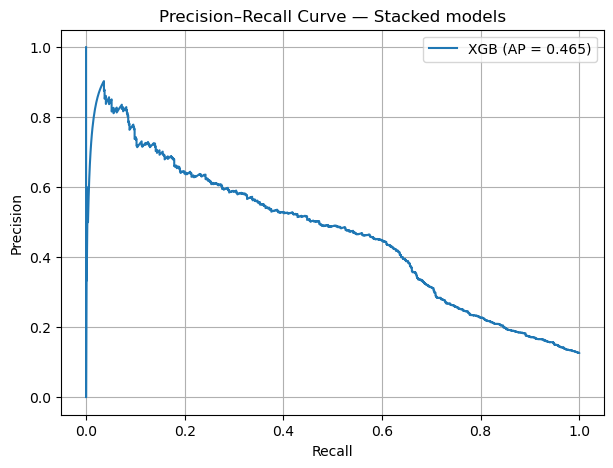

In [738]:
plt.figure(figsize=(7, 5))
plt.plot(stacked_recall, stacked_precision, label=f"XGB (AP = {stacked_ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Stacked models")
plt.legend()
plt.grid(True)
plt.show()

In [739]:
print(f"Stacked model recall @ precision≥0.35: {recall_at_precision(y_test, stacked_proba, 0.35):.3f}")

Stacked model recall @ precision≥0.35: 0.670


In [740]:
# Find threshold for precision >= 0.35 with max recall
idx = np.argmax(stacked_recall[:-1][stacked_precision[:-1] >= 0.35])
stacked_threshold = stacked_thresholds[stacked_precision[:-1] >= 0.35][idx]

# Predictions at chosen threshold
y_pred_stacked = (stacked_proba >= stacked_threshold).astype(int)

# Evaluation
confusion_matrix(y_test, y_pred_stacked)

array([[4364,  960],
       [ 255,  517]])

In [741]:
print(classification_report(y_test, y_pred_stacked, digits=3))

              precision    recall  f1-score   support

           0      0.945     0.820     0.878      5324
           1      0.350     0.670     0.460       772

    accuracy                          0.801      6096
   macro avg      0.647     0.745     0.669      6096
weighted avg      0.869     0.801     0.825      6096



In [742]:
# Recall for all models at precision 0.35

print(f"Logistic Regression: {recall_at_precision(y_test, lr_proba, 0.35):.3f}")
print(f"Random Forest:       {recall_at_precision(y_test, rfc_proba, 0.35):.3f}")
print(f"XGBoost:             {recall_at_precision(y_test, xgb_proba, 0.35):.3f}")
print(f"Stacked model:       {recall_at_precision(y_test, stacked_proba, 0.35):.3f}")

Logistic Regression: 0.639
Random Forest:       0.667
XGBoost:             0.674
Stacked model:       0.670
